In [17]:
# %pip install onnxruntime pillow numpy scikit-image

Model Inputs:
Name: input.1, Shape: [1, 3, 320, 320], Type: tensor(float)


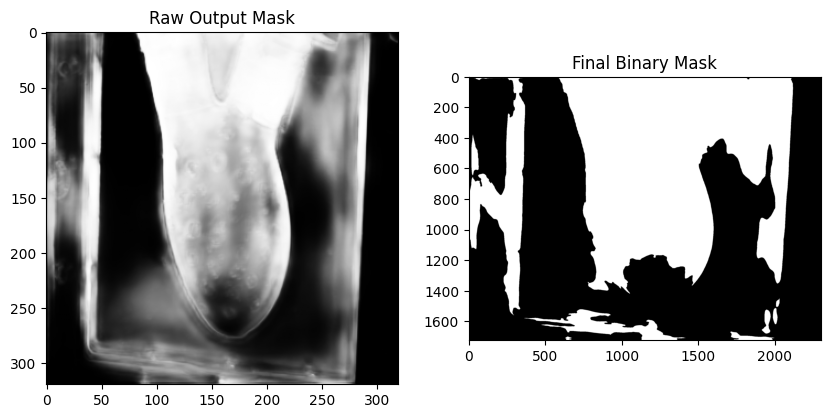

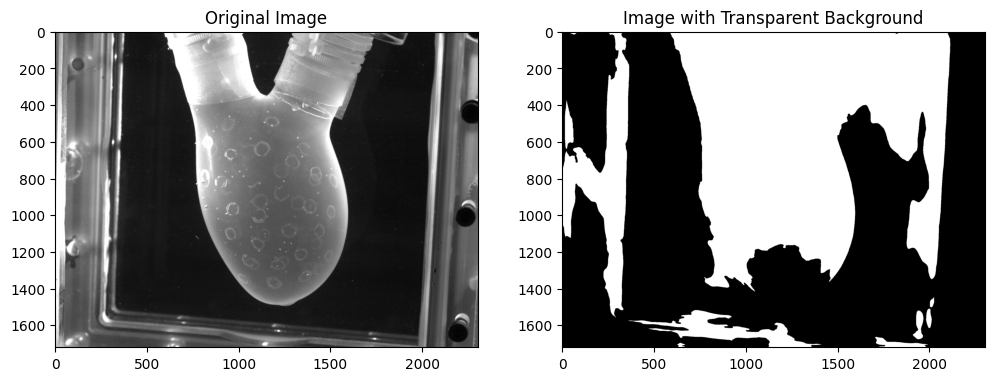

In [21]:
import numpy as np
import imageio.v2 as imageio
from skimage import transform
import onnxruntime as ort
import matplotlib.pyplot as plt
from skimage import morphology, transform
import scipy.ndimage as ndimage
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

def preprocess_grayscale_image(input_path):
    """Load grayscale image using imageio and prepare for model"""
    img = imageio.imread(input_path)

    # Handle different formats: grayscale, RGB, RGBA
    if len(img.shape) == 2:
        h, w = img.shape
        # Grayscale -> RGB by repeating the same channel 3 times
        img = np.stack([img] * 3, axis=-1)
    elif img.shape[2] == 4:
        # RGBA -> RGB
        img = img[:, :, :3]
    else:
        h, w = img.shape[:2]

    # Resize to model input size (e.g., 320x320)
    resized_img = transform.resize(img, (320, 320), mode='constant', preserve_range=True)

    # Normalize to [0, 1] float32
    normalized_img = resized_img.astype(np.float32) / 255.0

    # HWC -> CHW
    chw_img = np.transpose(normalized_img, (2, 0, 1))  # (3, 320, 320)

    # Add batch dimension -> (1, 3, 320, 320)
    batch_img = chw_img[np.newaxis, :, :, :]

    return batch_img, w, h



def postprocess_mask(mask, original_w, original_h, threshold=0.5):
    """
    Converts raw ONNX output to cleaned binary mask.
    
    Args:
        mask (np.ndarray): Raw model output of shape (1, 1, H, W)
        threshold (float): Value to separate foreground/background
    Returns:
        binary_mask (np.ndarray): Cleaned binary mask of shape (H, W)
    """
    # Remove batch and channel dims
    mask = np.squeeze(mask)

    # Resize back to original size
    mask_resized = transform.resize(mask, (original_h, original_w), preserve_range=True)

    # Threshold the mask
    binary_mask = (mask_resized > threshold).astype(np.float32)

    # Optional: Morphological cleanup
    binary_mask = morphology.binary_closing(binary_mask, morphology.disk(3))
    binary_mask = morphology.remove_small_objects(binary_mask.astype(bool), min_size=500)
    binary_mask = ndimage.binary_fill_holes(binary_mask)

    return binary_mask.astype(np.float32)


# def postprocess_mask(mask, original_w, original_h):
#     """Resize mask to original size and threshold it"""
#     mask = np.squeeze(mask)  # Remove batch/channel dim
#     mask = transform.resize(mask, (original_h, original_w), mode='constant', preserve_range=True)
#     binary_mask = (mask > 0.5).astype(np.float32)  # Threshold at 0.5
#     return binary_mask


def apply_mask_to_grayscale(image_path, binary_mask):
    """
    Applies binary mask to grayscale image and returns RGBA image with transparency.

    Parameters:
        image_path (str): Path to input image (grayscale or RGB)
        binary_mask (np.ndarray): Binary mask of shape (H, W), dtype=bool or float [0..1]

    Returns:
        rgba_img (np.ndarray): RGBA image with background removed
    """
    # Load image
    img = imageio.imread(image_path)

    # Handle different formats
    if len(img.shape) == 2:
        # Grayscale -> RGB
        rgb_img = np.stack([img] * 3, axis=-1)
    elif img.shape[2] == 1:
        # Single-channel image -> RGB
        rgb_img = np.concatenate([img] * 3, axis=2)
    elif img.shape[2] == 4:
        # RGBA -> RGB
        rgb_img = img[:, :, :3]
    else:
        rgb_img = img  # Assume RGB already

    # Ensure binary_mask is 2D and float32
    binary_mask = binary_mask.astype(np.float32)

    # Create alpha channel from mask (scale to 0–255)
    alpha = (binary_mask * 255).astype(np.uint8)

    # Stack RGB + Alpha
    rgba_img = np.dstack((rgb_img, alpha))

    return rgba_img


# Paths
input_image = "../img/cam0.tif"
model_path = "u2netp.onnx"

# Step 1: Preprocess image
input_tensor, orig_w, orig_h = preprocess_grayscale_image(input_path=input_image)

# Step 2: Load ONNX model
ort_session = ort.InferenceSession(model_path)

print("Model Inputs:")
for inp in ort_session.get_inputs():
    print(f"Name: {inp.name}, Shape: {inp.shape}, Type: {inp.type}")

# Step 3: Run inference
outputs = ort_session.run(
    None,
    {'input.1': input_tensor},
)

plt.show()

# Step 4: Postprocess output
final_mask = postprocess_mask(outputs[0], orig_w, orig_h)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Raw Output Mask")
plt.imshow(np.squeeze(outputs[0]), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Final Binary Mask")
plt.imshow(final_mask, cmap='gray')



# Step 5: Apply mask to original image
final = apply_mask_to_grayscale(input_image, final_mask)

# Step 6: Save result
# output_path = "output_with_transparency.png"
# imageio.imwrite(output_path, final_rgba)
# print(f"Background removed and saved as {output_path}")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(imageio.imread(input_image), cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(final_mask, cmap='gray')
ax[1].set_title("Image with Transparent Background")
plt.show()


In [19]:
import onnxruntime as ort

# Load the model and print input names
model_path = "u2netp.onnx"
session = ort.InferenceSession(model_path)

print("Model Inputs:")
for inp in session.get_inputs():
    print(f"Name: {inp.name}, Shape: {inp.shape}, Type: {inp.type}")

Model Inputs:
Name: input.1, Shape: [1, 3, 320, 320], Type: tensor(float)


In [20]:
import numpy as np
import onnxruntime as ort

# Assume input_tensor has shape (1, 3, 320, 320)
inputs = {
    'input': input_tensor,
    'input.1': np.zeros((1, 16, 40, 40), dtype=np.float32)  # Dummy tensor
}

# Now run inference
outputs = ort_session.run(None, inputs)

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input.1 for the following indices
 index: 1 Got: 16 Expected: 3
 index: 2 Got: 40 Expected: 320
 index: 3 Got: 40 Expected: 320
 Please fix either the inputs/outputs or the model.